In [39]:
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random as rd
import matplotlib.pyplot as plt

In [3]:
# Seed
seed = rd.randint(0,99999999)

In [4]:
df = pd.read_csv('complete_dataset.csv')

In [5]:
df.head()

,Unnamed: 0,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
0,0,111.206245,-128.070497,582.026580,239.276743,0.205634,84.763748,-89.000926,1
1,1,117.477703,-132.831311,554.636573,250.309014,0.199645,88.426733,-92.060480,1
2,2,111.984444,-133.417261,636.900253,245.401704,0.193656,87.221721,-93.731053,1
3,3,114.831800,-148.762000,497.157678,263.593800,0.187666,96.151949,-108.130415,1
4,4,100.741600,-122.019000,609.328195,222.760600,0.183673,83.015207,-90.556571,1


In [6]:
df.tail()

,Unnamed: 0,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
50,50,93.579555,-142.099047,703.929038,235.678601,0.192003,77.378071,-99.576142,0
51,51,0.000000,-129.023850,629.446398,0.000000,0.000000,65.455168,-90.572485,0
52,52,107.623529,-130.686378,546.450781,238.309908,0.188003,82.729708,-88.611173,0
53,53,85.166931,-104.910982,686.594488,190.077913,0.188003,67.804083,-74.661710,0
54,54,85.041928,-109.342301,665.782497,194.384229,0.192003,64.283984,-73.564895,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      55 non-null     int64  
 1   corrente_anodica                55 non-null     float64
 2   corrente_catodica               55 non-null     float64
 3   carga                           55 non-null     float64
 4   diff_corrente_anodica_catodica  55 non-null     float64
 5   diff_pot_anodico_catodico       55 non-null     float64
 6   pico_derivada_anodica           55 non-null     float64
 7   pico_derivada_catodica          55 non-null     float64
 8   target                          55 non-null     int64  
dtypes: float64(7), int64(2)
memory usage: 4.0 KB


In [8]:
df.head()

,Unnamed: 0,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
0,0,111.206245,-128.070497,582.026580,239.276743,0.205634,84.763748,-89.000926,1
1,1,117.477703,-132.831311,554.636573,250.309014,0.199645,88.426733,-92.060480,1
2,2,111.984444,-133.417261,636.900253,245.401704,0.193656,87.221721,-93.731053,1
3,3,114.831800,-148.762000,497.157678,263.593800,0.187666,96.151949,-108.130415,1
4,4,100.741600,-122.019000,609.328195,222.760600,0.183673,83.015207,-90.556571,1


In [37]:
# Preparando os dados
X = df.iloc[:,1:-1]
y = df['target']

cv = KFold(n_splits = 5, random_state=seed, shuffle=True)
#Create a model for logistic regression
model = LogisticRegression(max_iter=1000)
scores = cross_validate(model, X.values, y.values, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
print("Acurracy %.3f", np.mean(np.mean(scores['test_score'])))

Acurracy %.3f 0.890909090909091


Fold 0
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




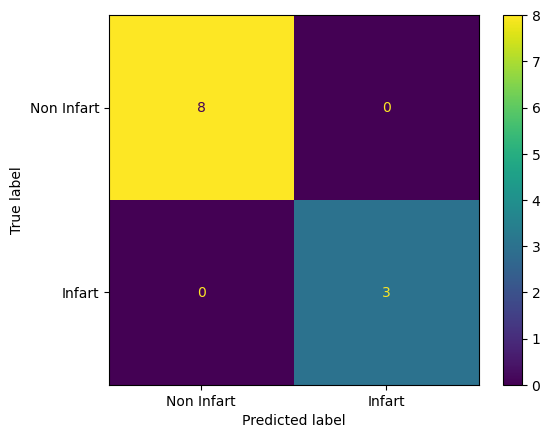

Fold 1
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




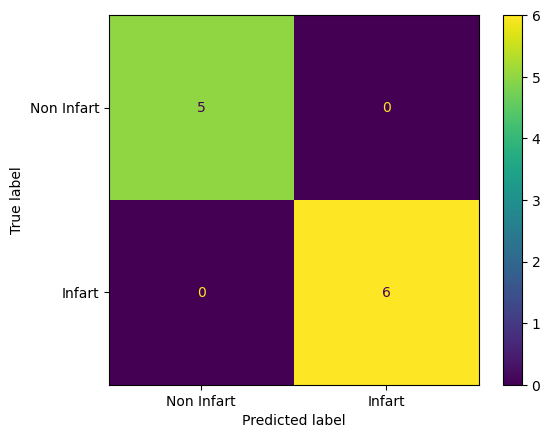

Fold 2
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




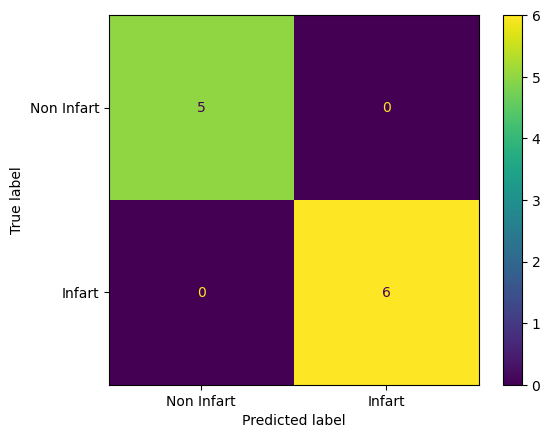

Fold 3
Number of samples: 11
Mean Specificity= 0.7142857142857143
Mean Sensibility= 0.75




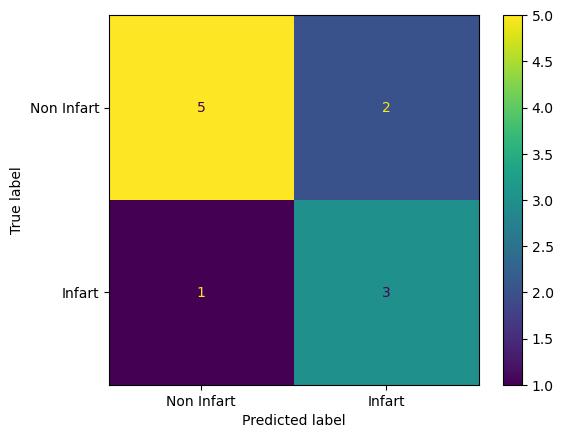

Fold 4
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 0.8571428571428571




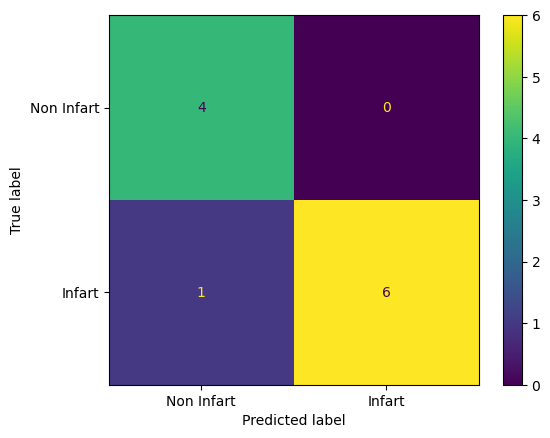

Mean Specificity= 0.9428571428571428 Std: 0.11428571428571428
Mean Sensibility= 0.9214285714285714  Std: 0.10202040612204072


In [47]:
list_specificity = []
list_sensibility = []
estimator = scores['estimator'][0]

for i, (train_index, test_index) in enumerate(cv.split(X.values)):
    
    X_pred = X.iloc[test_index].values
    y_ground = y.iloc[test_index].values
    y_pred = estimator.predict(X_pred)
    tn, fp, fn, tp = confusion_matrix(y_ground, y_pred).ravel()
    sensibility = tp / (tp + fn)
    specificity = tn / (tn + fp)
    list_sensibility.append(sensibility)
    list_specificity.append(specificity)
    
    print(f"Fold {i}")
    print(f'Number of samples: {len(X_pred)}')
    print(f"Mean Specificity= {specificity}")
    print(f"Mean Sensibility= {sensibility}\n\n")
  
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_ground, y_pred), display_labels=['Non Infart', 'Infart']).plot()
    plt.grid(False)
    plt.show()
    
print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")

Number of samples: 55
Mean Specificity= 0.9310344827586207
Mean Sensibility= 0.9230769230769231




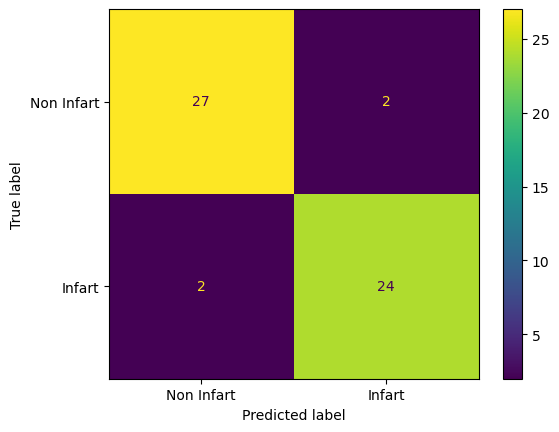

In [48]:
# Verificando com todos os elementos
X_pred = X.values
y_truth = y.values
y_pred = estimator.predict(X_pred)
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
sensibility = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Number of samples: {len(X_pred)}')
print(f"Specificity= {specificity}")
print(f"Sensibility= {sensibility}\n\n")
  
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
plt.grid(False)
plt.show()